In [99]:
CLIENT_ID = ""********""
CLIENT_SECRET = "-"********""

In [100]:
USER_AGENT = "python:data_miner (by /u/mgautam96)"

In [101]:
USERNAME = "********"
PASSWORD = "********"

In [102]:
import requests

def login(username, password):
    if password is None:
        password = getpass.getpass("Enter reddit password for user {}: ".format(username))
    headers = {"User-Agent": USER_AGENT}
    client_auth = requests.auth.HTTPBasicAuth(CLIENT_ID, CLIENT_SECRET)
    post_data = {"grant_type": "password", "username": username, "password": password}
    response = requests.post("https://www.reddit.com/api/v1/access_token", auth=client_auth, data=post_data, headers=headers)
    return response.json()


In [103]:
token = login(USERNAME, PASSWORD)

In [104]:
subreddit = "worldnews"

In [105]:
url = "https://oauth.reddit.com/r/{}".format(subreddit)

In [106]:
headers = {"Authorization": "bearer {}".format(token['access_token']),
           "User-Agent": USER_AGENT}


In [107]:
response = requests.get(url, headers=headers)

In [108]:
result = response.json()

In [109]:
for story in result['data']['children']:
    print(story['data']['title'])

Skeptics Blast Trump's New Claim That Soleimani Targeted 4 US Embassies: "Either Fox News gets higher level briefings than Congress ... or there was no such imminent threat," charged Sen. Chris Murphy.
The US reportedly sent secret messages to Iran via Swiss intermediaries, urging not to retaliate too strongly and further provoke Trump
Ontario Provincial government sends mass alert for ‘incident’ at nuclear facility
Trump Brags About Serving Up American Troops to Saudi Arabia for Nothing More Than Cash: Justin Amash responded to Trump's remarks, saying, “He sells troops”
Prague mayor hits out at ‘unreliable’ China as city ditches Beijing for Taipei in sister city agreement
Choppers are used to drop thousands of kilograms of food for animals starving to death bushfires | Daily Mail Online
China will not change its position that Taiwan belongs to it and the world will only ever recognize that there is “one China”, Beijing said on Sunday after President Tsai Ing-wen won re-election and sa

In [110]:
from time import sleep


In [111]:
def get_links(subreddit, token, n_pages=5):
    stories = []
    after = None
    for page_number in range(n_pages):
        headers = {"Authorization": "bearer {}".format(token['access_token']),
            "User-Agent": USER_AGENT}
        url = "https://oauth.reddit.com/r/{}?limit=100".format(subreddit)
        if after:
            url += "&after={}".format(after)
        response = requests.get(url, headers=headers)
        result = response.json()
        after = result['data']['after']
        sleep(2)
        stories.extend([(story['data']['title'], story['data']['url'], story['data']['score'])
                       for story in result['data']['children']])
        return stories

In [112]:
stories = get_links("worldnews", token)

In [113]:
import os
data_folder = os.path.join(os.path.expanduser("~/workspace"), "Data", "websites", "raw")

In [114]:
import hashlib

In [115]:
number_errors = 0

In [118]:
from interruptingcow import timeout

In [120]:
for title, url, score in stories:
    output_filename = hashlib.md5(url.encode()).hexdigest()
    fullpath = os.path.join(data_folder, output_filename + ".txt")
    try:
        with timeout(5, exception=RuntimeError):
            response = requests.get(url)
            sleep(2)
            data = response.text
            with open(fullpath, 'w') as outf:
                outf.write(data)
    except (Exception, RuntimeError) as e:
        number_errors += 1
        print(e)

In [121]:
filenames = [os.path.join(data_folder, filename)
             for filename in os.listdir(data_folder)]

In [122]:
text_output_folder = os.path.join(os.path.expanduser("~/workspace"), "Data",
                                  "websites", "textonly")

In [123]:
from lxml import etree
from lxml.html import parse

In [124]:
skip_node_types = ["script", "head", "style", etree.Comment]

In [125]:
def get_text_from_file(filename):
    with open(filename) as inf:
        html_tree = parse(inf)
    return get_text_from_node(html_tree.getroot())

In [126]:
def get_text_from_node(node):
    if len(node) == 0:
        if node.text and len(node.text) > 100:
            return node.text
        else:
            return ""
    results = (get_text_from_node(child) for child in node
                     if child.tag not in skip_node_types)
    return "\n".join(r for r in results if len(r) > 1)

In [127]:
for filename in os.listdir(data_folder):
    text = get_text_from_file(os.path.join(data_folder, filename))
    with open(os.path.join(text_output_folder, filename), 'w') as outf:
        outf.write(text)

In [128]:
from sklearn.cluster import KMeans

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [162]:
from sklearn.pipeline import Pipeline
n_clusters = 10
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])

In [131]:
documents = [open(os.path.join(data_folder, filename)).read() for filename in os.listdir(data_folder)]

In [132]:
pipeline.fit(documents)
labels = pipeline.predict(documents)

In [133]:
from collections import Counter
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 7 samples
Cluster 1 contains 25 samples
Cluster 2 contains 6 samples
Cluster 3 contains 9 samples
Cluster 4 contains 14 samples
Cluster 5 contains 5 samples
Cluster 6 contains 8 samples
Cluster 7 contains 5 samples
Cluster 8 contains 8 samples
Cluster 9 contains 11 samples


In [134]:
pipeline.named_steps['clusterer'].inertia_

65.60822081909664

In [135]:
inertia_scores = []
n_cluster_values = range(2, 15)
for n_clusters in n_cluster_values:
    cur_inertia_scores = []
    X = TfidfVectorizer(max_df=0.4).fit_transform(documents)
    km = KMeans(n_clusters=n_clusters).fit(X)
    print(km.inertia_)
    cur_inertia_scores.append(km.inertia_)
    inertia_scores.append(cur_inertia_scores)

90.6645741923784
87.08095238137
83.94059363364067
79.46146247803802
76.9464730972924
72.70772762633524
69.71910858237742
67.89873508123442
64.96467970033173
64.6039302829198
62.084176780317655
60.2517595687025
57.68087734356895


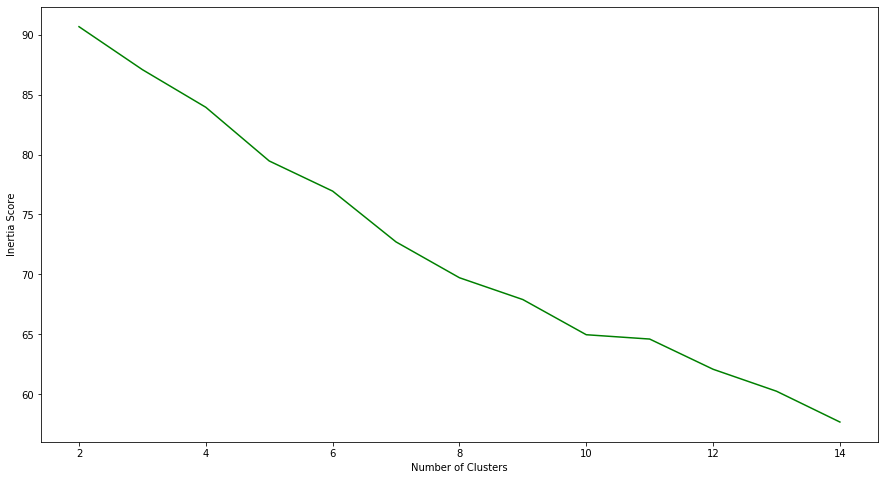

In [136]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15, 8))
plt.plot(n_cluster_values, inertia_scores, color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.show()

In [196]:
n_clusters = 10
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])
pipeline.fit(documents)
labels = pipeline.predict(documents)

In [197]:
terms = pipeline.named_steps['feature_extraction'].get_feature_names()

In [198]:
c = Counter(labels)

In [199]:
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 3 samples
Cluster 1 contains 5 samples
Cluster 2 contains 5 samples
Cluster 3 contains 7 samples
Cluster 4 contains 6 samples
Cluster 5 contains 13 samples
Cluster 6 contains 25 samples
Cluster 7 contains 7 samples
Cluster 8 contains 10 samples
Cluster 9 contains 17 samples


In [200]:
print("  Most important terms")
centroid = pipeline.named_steps['clusterer'].cluster_centers_[cluster_number]
most_important = centroid.argsort()

  Most important terms


In [201]:
for i in range(10):
    term_index = most_important[-(i+1)]
    print("  {0}) {1} (score: {2:.4f})".format(i+1, terms[term_index], centroid[term_index]))

  1) field (score: 0.1512)
  2) views (score: 0.1130)
  3) td (score: 0.0874)
  4) commondreams (score: 0.0620)
  5) option (score: 0.0452)
  6) files (score: 0.0449)
  7) pulse (score: 0.0403)
  8) fa (score: 0.0392)
  9) wp (score: 0.0384)
  10) dailymail (score: 0.0383)


In [202]:
X = pipeline.transform(documents)
X.shape

(98, 10)

In [203]:
from scipy.sparse import csr_matrix

In [204]:
import numpy as np

In [205]:
def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')

In [206]:
C = create_coassociation_matrix(labels)

In [207]:
len(C.nonzero()[0]) / (C.shape[0] * C.shape[1])

0.14327363598500625

In [208]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [209]:
mst = minimum_spanning_tree(C)

In [210]:
mst = minimum_spanning_tree(-C)

In [211]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=3))
                     ])
pipeline.fit(documents)
labels2 = pipeline.predict(documents)
C2 = create_coassociation_matrix(labels2)
C_sum = (C + C2) / 2

In [212]:
mst = minimum_spanning_tree(-C_sum)
mst.data[mst.data > -1] = 0

In [213]:
from scipy.sparse.csgraph import connected_components
number_of_clusters, labels = connected_components(mst)

In [218]:
from sklearn.base import BaseEstimator, ClusterMixin
class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=10, cut_threshold=0.5, n_clusters_range=(3, 10)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
        
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X)) for i in range(self.n_clusterings)))
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        self.n_components, self.labels_ = connected_components(mst)
        return self
    
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [219]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', EAC())
                     ])
pipeline.fit(documents)
labels = pipeline.named_steps['clusterer'].labels_
c = Counter(labels)
c

Counter({0: 98})

In [221]:
from sklearn.feature_extraction.text import HashingVectorizer
vec = TfidfVectorizer(max_df=0.4)
X = vec.fit_transform(documents)

In [222]:
from sklearn.cluster import MiniBatchKMeans
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)

In [223]:
batch_size = 10
for iteration in range(int(X.shape[0] / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    mbkm.partial_fit(X[start:end])

In [224]:
labels  = mbkm.predict(X)

In [226]:
class PartialFitPipeline(Pipeline):
    def partial_fit(self, X, y=None):
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        return self.steps[-1][1].partial_fit(Xt, y=y)

In [227]:
pipeline = PartialFitPipeline([('feature_extraction', HashingVectorizer()),
                             ('clusterer', MiniBatchKMeans(random_state=14, n_clusters=3))
                             ])
batch_size = 10
for iteration in range(int(len(documents) / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    pipeline.partial_fit(documents[start:end])
labels = pipeline.predict(documents)

In [228]:
labels

array([1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)